# A comparison of ecmtool and mptool on E. coli core metabolic model

## Heatmaps and correlation plots
In this section I explore the results from mptool and ecmtool respectively. ecmtool found in total 689 ECMs (Clement et al. 2021), while mptool found 33 MPs. To make a more fair comparison, ECMs that did not produce biomass were filtered out, which left 613 ECMs. 

### MPs

In [2]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv
from collections import defaultdict, Counter
from itertools import product
from fractions import Fraction as frac

%matplotlib inline
sns.set(font_scale=1.5, style='ticks')

In [47]:
# Read mps from csv file
mps_ecolic = []
with open('mps/e_coli_core_20220207_1231540486324_complete_mps.csv', newline='\n') as mpfile:
    mps_in_csv = csv.reader(mpfile, delimiter = ',')
    for mp in mps_in_csv:
        mps_ecolic.append(set(mp))
        
# Read dictionary of sensible names for plotting
names = dict()
f = open("mps/e_coli_core_metabnames_mps.csv", newline = '\n')
for line in f:
    line = line.strip('\r\r\n')
    (key, val) = line.split(",")
    names[key] = val

# Rename the metabolites in each set
for i in range(len(mps_ecolic)):
    mps_ecolic[i] = set(names.get(metab) for metab in mps_ecolic[i])

<Figure size 432x288 with 0 Axes>

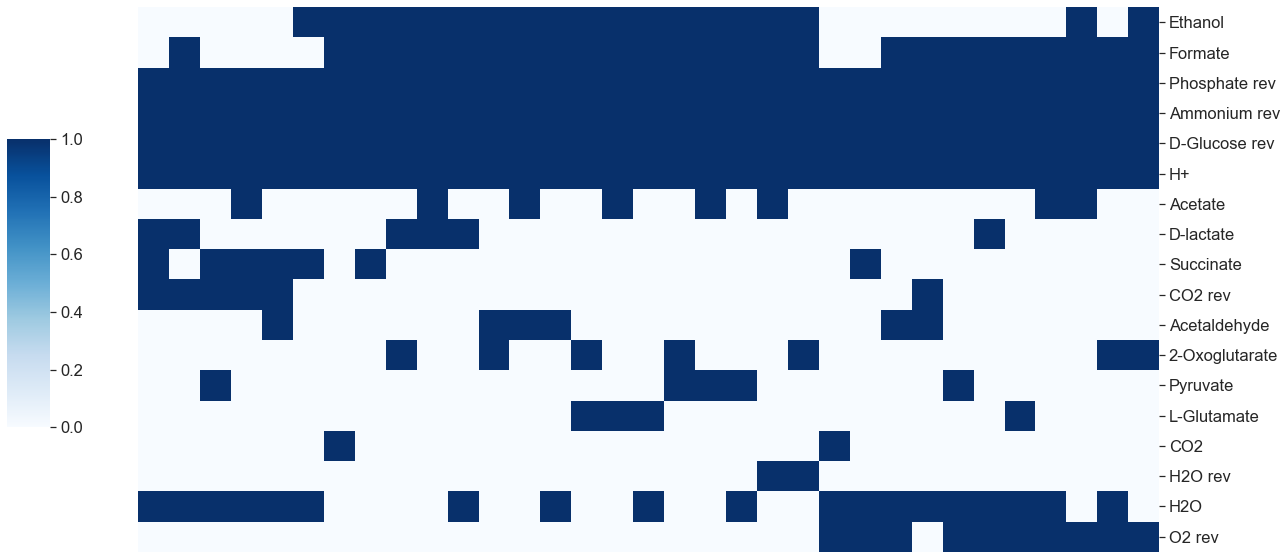

In [26]:
# Create clustered heatmap visualizing which metabolites are present in each mp
mp_occur_ecolic = pd.DataFrame({i: {x: 1 for x in mp} for i, mp in enumerate(mps_ecolic)}).fillna(0)

# Render figure
f = plt.figure()
g = sns.clustermap(mp_occur_ecolic, col_cluster=True, cmap='Blues', xticklabels=0, yticklabels=1, figsize=(20, 10))
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.fig.subplots_adjust(right=0.9)
g.ax_cbar.set_position((0.1, .2, .03, .4))

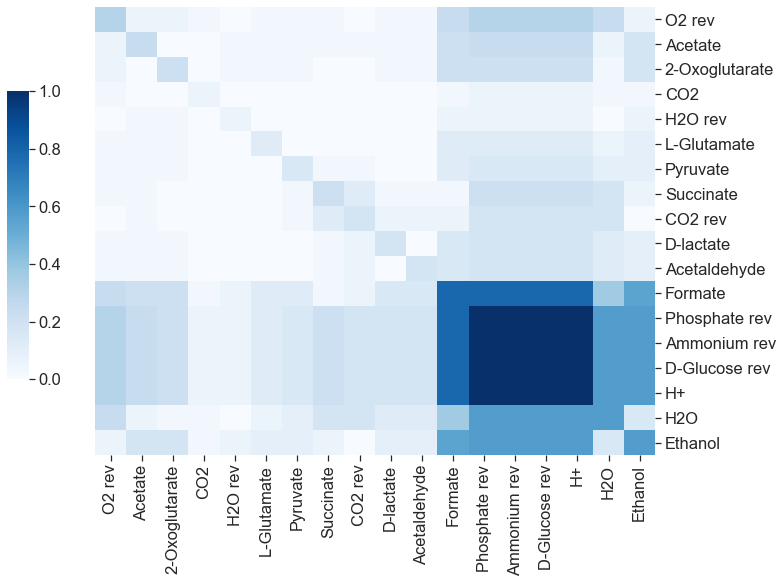

In [27]:
# Plot correlation
# Count number of times reactions (exchanged metabolites) occur together in MPs
d = defaultdict(dict)
for mp in mps_ecolic:
    for x1, x2 in product(mp, repeat=2):
        try:
            d[x1][x2] += 1
        except KeyError:
            d[x1][x2] = 1
mp_corr = pd.DataFrame(d).fillna(0)

# Convert counts to fractions
mp_corr = mp_corr / len(mps_ecolic)

# Cluster reactions (exchanged metabolites) by co-occurence
g = sns.clustermap(mp_corr, cmap='Blues', xticklabels=1, yticklabels=1)
g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.fig.subplots_adjust(right=1)
g.ax_cbar.set_position((0.1, 0.3, 0.03, 0.4))

### ECMs

I did recreate the plot found in the paper on ECM, which can be compared to the first heatmap of the MPs. However, I created a new plot that adds metabolites in the "reverse reaction". Reverse reactions are the metabolites that, if they are both consumed and produced by the cell through different ecms, they are split so that the "reverse reaction" is the reaction where they are consumed by the cell. I found out that might not be the case for MP afterall, since I haven't been provided with stoichiometry yet. I will fix this in the future, but it will have to stay like this for now. I also make a plot describing which metabolites occur together in the same ECM, as I did with MPs. 

In [28]:
# Read ECMs
ecms_ecolic = pd.read_csv('ecms/results/e_coli_core_ecm_df.csv')

# Drop the first column (an unnecessary index)
ecms_ecolic = ecms_ecolic.iloc[:, 1:]

# Convert stoichiometry to fractions, THEN convert to floats
ecms_ecolic = ecms_ecolic.applymap(frac)
ecms_ecolic = ecms_ecolic.applymap(float)

# Drop unused metabolites
ecms_ecolic = ecms_ecolic.loc[:, (ecms_ecolic != 0).any(axis = 0)]

# Filter ECMs that produce biomass
ecms_ecolic = ecms_ecolic.loc[ecms_ecolic['objective'] != 0]

# Remove column with biomass
ecms_ecolic.drop('objective', axis = 1, inplace = True)

# Find metabolites that have either all positive/zero or all negative/zero stoichiometry across all ECMs
strict_metabs = (ecms_ecolic <= 0).all(axis = 0) | (ecms_ecolic >= 0).all(axis = 0)
rev_metabs = [metab for metab, strict in strict_metabs.iteritems() if not strict]
rev_names = ['{}_rev'.format(metab) for metab in rev_metabs] # Give the new columns names that ends with '_rev'

# Make new columns for "reversible metabolites"
for metab, reversible in zip(rev_metabs, rev_names):
    ecms_ecolic[reversible] = ecms_ecolic[metab]
    ecms_ecolic[metab] = ecms_ecolic[metab].clip(lower = 0)
    ecms_ecolic[reversible] = ecms_ecolic[reversible].clip(upper = 0)

# Rename metabolites that are only consumed
neg_metabs = (ecms_ecolic <= 0).all(axis=0)
neg_metabs = [metab for metab, neg in neg_metabs.iteritems() if neg and not metab.endswith('_rev')]

for metab in neg_metabs:
    ecms_ecolic.rename(columns={metab:'{}_rev'.format(metab)}, inplace=True)    

# Check if values were changed correctly in the for loop above:
# print((ecms_ecolic['M_co2_e'] >= 0).all(axis=0))
# print((ecms_ecolic['CO2 reverse'] <= 0).all(axis=0))

In [29]:
# Change name of columns to readable metabolite names
ids_to_names = dict()
f = open("ecms/results/e_coli_core_metabnames.csv", newline = '\n')
for line in f:
    line = line.strip('\r\r\n')
    (key, val) = line.split(",")
    ids_to_names[key] = val

# Add entries for reverse reactions to ID to names dictionary
for ID in ecms_ecolic.columns:
    if ID.endswith('_rev'):
        ids_to_names[ID] = '{} rev'.format(ids_to_names[ID.replace('_rev', '')])

# Rename all columns to name instead of ID
ecms_ecolic.rename(columns = ids_to_names, inplace = True)

In [30]:
# Collect all metabolites that occur for each ecm
metabs_in_ecms_ecolic = []
for ecm in range(ecms_ecolic.shape[0]):
    metabs = set()
    for metab in range(ecms_ecolic.shape[1]):
        if ecms_ecolic.iloc[ecm][metab] != 0:
            metabs.add(ecms_ecolic.columns[metab])
    metabs_in_ecms_ecolic.append(metabs)

c:\users\ylvaw\pycharmprojects\masteroppgave-pathway-analysis\venv\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

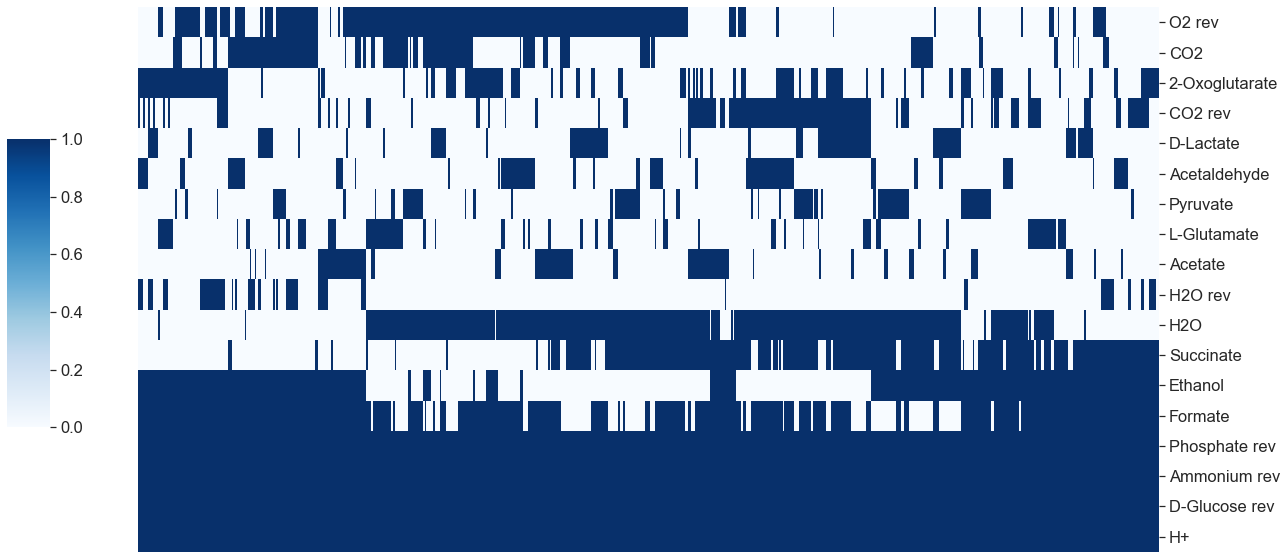

In [31]:
# Dataframe of metabolite counts in all ecms.
ecm_occur_ecolic = pd.DataFrame({i: {x: 1 for x in ecm} for i, ecm in enumerate(metabs_in_ecms_ecolic)}).fillna(0)

# Sum rows and divide by no. ecms to get frequency across ecms
ecm_occur_ecolic.sum(axis=1) / ecm_occur_ecolic.shape[1]

# Render figure
f = plt.figure()
g = sns.clustermap(ecm_occur_ecolic, col_cluster=True, cmap='Blues', xticklabels=0, yticklabels=1, figsize=(20, 10))
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.fig.subplots_adjust(right=0.9)
g.ax_cbar.set_position((0.1, .2, .03, .4))

In [32]:
# Correlation plot for ecms    
d = defaultdict(dict)
for ecm in metabs_in_ecms_ecolic:
    for x1, x2 in product(ecm, repeat=2):
        try:
            d[x1][x2] += 1
        except KeyError:
            d[x1][x2] = 1
ecm_corr = pd.DataFrame(d).fillna(0)

# Convert counts to fractions
ecm_corr = ecm_corr / ecms_ecolic.shape[0]

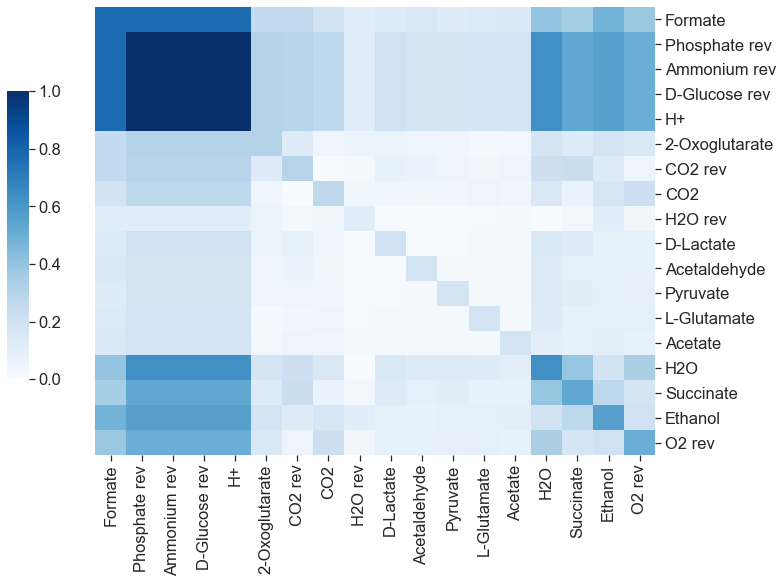

In [33]:
# Cluster reactions (exchanged metabolites) by co-occurence
g = sns.clustermap(ecm_corr, cmap='Blues', xticklabels=1, yticklabels=1)
g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.fig.subplots_adjust(right=1)
g.ax_cbar.set_position((0.1, 0.3, 0.03, 0.4))

All metabolites present in the MPs were found in the ECMs, except O2 reverse! This exchange metabolite describes the production of O2 (I think)? In addition, both methods seem to cluster the same metabolites together.

## Direct comparisons 

Now that we have explored each result independently, it is time to compare them. What is most interesting here is to compare which metabolites were included in the space of ECMs compared to MPs. I plot the distribution of number of exchange reactions across MPs and ECMs, distribution of how many ECMs were found to be supersets of each MP, which metabolites do these contain/not contain and compute distance between the MPs and ECMs. 

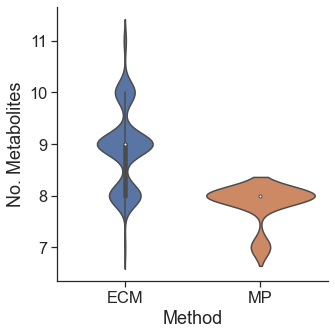

In [34]:
# No. metabolites that occured in each of their respective MPs and ECMs
ecm_tally_ecolic = ecm_occur_ecolic.sum(axis=0)
mp_tally_ecolic = mp_occur_ecolic.sum(axis=0)

# Make plot dataframe
plotdata = pd.DataFrame(pd.concat([ecm_tally_ecolic, mp_tally_ecolic]), columns = ['No. Metabolites'])
plotdata['Method'] = ['ECM']*ecm_occur_ecolic.shape[1] + ['MP']*mp_occur_ecolic.shape[1]

# Render plot
sns.catplot(data = plotdata, x = 'Method', y = 'No. Metabolites', kind = 'violin')

In general, there are more metabolites included in the ECMs than in the MPs. This makes sense, as the MPs try to compute the minimal set of exchange metabolites the organism in question need, given a set of conditions.

In [35]:
# Iterate over all metabolites in MPs to find the same set of metabolites in ECMs
mps_in_ecms_ecolic = [0]*len(mps_ecolic)
for i in range(len(mps_ecolic)):
    for ecm in metabs_in_ecms_ecolic:
        if mps_ecolic[i].issubset(ecm):
            mps_in_ecms_ecolic[i] += 1

# This MP was subset of most ECMs
# mps_ecolic[mps_in_ecms_ecolic.index(max(mps_in_ecms_ecolic))]

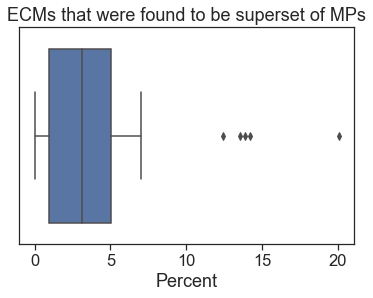

In [36]:
# Of the MPs that were subset of ECMs, how many ECMs were they a subset of?
mps_in_ecms_distr = [num for num in mps_in_ecms_ecolic if num != 0]
mps_in_ecms_distr = [num/ecms_ecolic.shape[0]*100 for num in mps_in_ecms_ecolic]

bp = sns.boxplot(data = mps_in_ecms_distr, orient = 'h')
bp.set(xlabel='Percent', 
       title = 'ECMs that were found to be superset of MPs', 
       yticklabels = [])
bp.tick_params(left=False)
plt.show()

Most MPs that were subset of ECMs were subsets of about 3% of all ECMs. This however is not entirely accurate, since I found out in hindsight that many of the ECMs have the exact same metabolites included. Not all ECMs are unique because the stoichiometry is disregarded. Therefore the percentage might be even higher. I fixed this issue further down in the notebook.

In [37]:
# What metabolites do the MPs that were a part of ECMs have in common?

# Extract MPs that are in ECMs
idx_mps_in_ecms = [idx for idx, x in enumerate(mps_in_ecms_ecolic) if x != 0]
mps_of_ecms = [mps_ecolic[i] for i in idx_mps_in_ecms]

# Find occurances of each metabolite in the MPs that were subset of ECM
metab_counter = Counter()
for mp in mps_of_ecms:
    metab_counter.update(mp)

# Scale according to metabolite frequency in the set of MPs that were subset of ECMs
for key, value in metab_counter.items():
    metab_counter[key] = value/len(mps_of_ecms)

In [38]:
# What metabolites do the MPs that were not a part of ECMs have in common?
plt.figure(figsize = (15,8))
plt.bar(metab_counter.keys(), metab_counter.values())
plt.xticks(rotation = 45)
plt.show()

In [39]:
# Extract MPs that are in ECMs
idx_mps_in_ecms = [idx for idx, x in enumerate(mps_in_ecms_ecolic) if x == 0]
mps_notof_ecms = [mps_ecolic[i] for i in idx_mps_in_ecms]
mps_notof_ecms

# Find occurances of each metabolite in the MPs that were subset of ECM
metab_counter = Counter()
for mp in mps_notof_ecms:
    metab_counter.update(mp)

# Scale for total MPs that were subset of 
for key, value in metab_counter.items():
    metab_counter[key] = value/len(mps_notof_ecms)

In [40]:
plt.figure(figsize = (15,8))
plt.bar(metab_counter.keys(), metab_counter.values())
plt.xticks(rotation = 45)
plt.show()

There are four metabolites that are present in all MPs, which seems to be the essential metabolites. Generally, the MPs that were not subset of ECMs have fewer metabolites. They don't contain Acetaldehyde, L-Glutamate, Pyruvate or production of CO2, but do contain D-lactate. 

In [41]:
# Create unique ECMs
set_ecms = set(frozenset(ecm) for ecm in metabs_in_ecms_ecolic)

# Calculate Jaccard distance between all MPs and ECMs
dist = np.zeros((len(mps_ecolic), len(set_ecms)))
for i, mp in enumerate(mps_ecolic):
    for j, ecm in enumerate(set_ecms):
        dist[i,j] = len(mp & ecm)/len(mp | ecm)

In [42]:
# Clustered heatmap of similarity
g = sns.clustermap(dist, col_cluster=True, cmap='Blues', xticklabels=0, yticklabels=1, figsize=(20, 10))

c:\users\ylvaw\pycharmprojects\masteroppgave-pathway-analysis\venv\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


The clustered heatmap shows Jaccard distance between all MPs and ECMs. There are mainly three blocks in the plot where MPs and ECMs are very similar. We found that MP 4 was the most similar over all to the other ECMs. Therefore we decided to check the distribution of distances for this MP.

In [45]:
# Distribution of similarity across ECMs for most similar MP
sns.histplot(dist[3])

<AxesSubplot:ylabel='Count'>

Looks relatively normally distributed. Most have a distance of over 0.6 which indicates a strong similarity between this MP and an ECM. 

In [46]:
# Which metabolites differ between the ECMs and the most similar MP?
# np.where(dist[3]>0.8)[0]
for ecm in np.array(list(set_ecms))[dist[3]>0.6]:
    print('Metabolites in this MP not in ECM: {}'.format(mps_ecolic[3] - ecm))
    print('Metabolites ECM not in this MP: {}'.format(ecm - mps_ecolic[3]))

Metabolites in this MP not in ECM: set()
Metabolites ECM not in this MP: frozenset({'Acetate'})
Metabolites in this MP not in ECM: set()
Metabolites ECM not in this MP: frozenset({'H2O', 'Acetate'})
Metabolites in this MP not in ECM: set()
Metabolites ECM not in this MP: frozenset({'CO2', 'O2 rev'})
Metabolites in this MP not in ECM: set()
Metabolites ECM not in this MP: frozenset({'Acetaldehyde', 'H2O', 'CO2 rev'})
Metabolites in this MP not in ECM: set()
Metabolites ECM not in this MP: frozenset({'L-Glutamate'})
Metabolites in this MP not in ECM: {'Formate'}
Metabolites ECM not in this MP: frozenset({'H2O', 'Acetate'})
Metabolites in this MP not in ECM: set()
Metabolites ECM not in this MP: frozenset({'H2O rev', 'CO2 rev'})
Metabolites in this MP not in ECM: set()
Metabolites ECM not in this MP: frozenset({'H2O', 'D-Lactate'})
Metabolites in this MP not in ECM: set()
Metabolites ECM not in this MP: frozenset({'CO2', 'L-Glutamate'})
Metabolites in this MP not in ECM: set()
Metabolites

Here we explore the union - intersection for all ECMs with a similarity above 0.6 to MP 4. There are mostly just a difference of 1-4 metabolites.

## Citations

Clement, T. J., Baalhuis, E. B., Teusink, B., Bruggeman, F. J., Planque, R., & De Groot, D. H. (2021). Unlocking Elementary Conversion Modes: ecmtool Unveils All Capabilities of Metabolic Networks. Patterns, 2(1). https://doi.org/ARTN 100177 10.1016/j.patter.2020.100177